<a href="https://colab.research.google.com/github/FiLM2072/measure-object-distance/blob/main/Computervision_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/FiLM2072/measure-object-distance.git"

fatal: destination path 'measure-object-distance' already exists and is not an empty directory.


In [2]:
import torch
import torchvision.transforms as T

#hekper function
def show(imgs):
    #Tensor->PIL
    img = T.ToPILImage()(imgs)
    #display
    display(img)

torch.Size([3, 758, 1011])


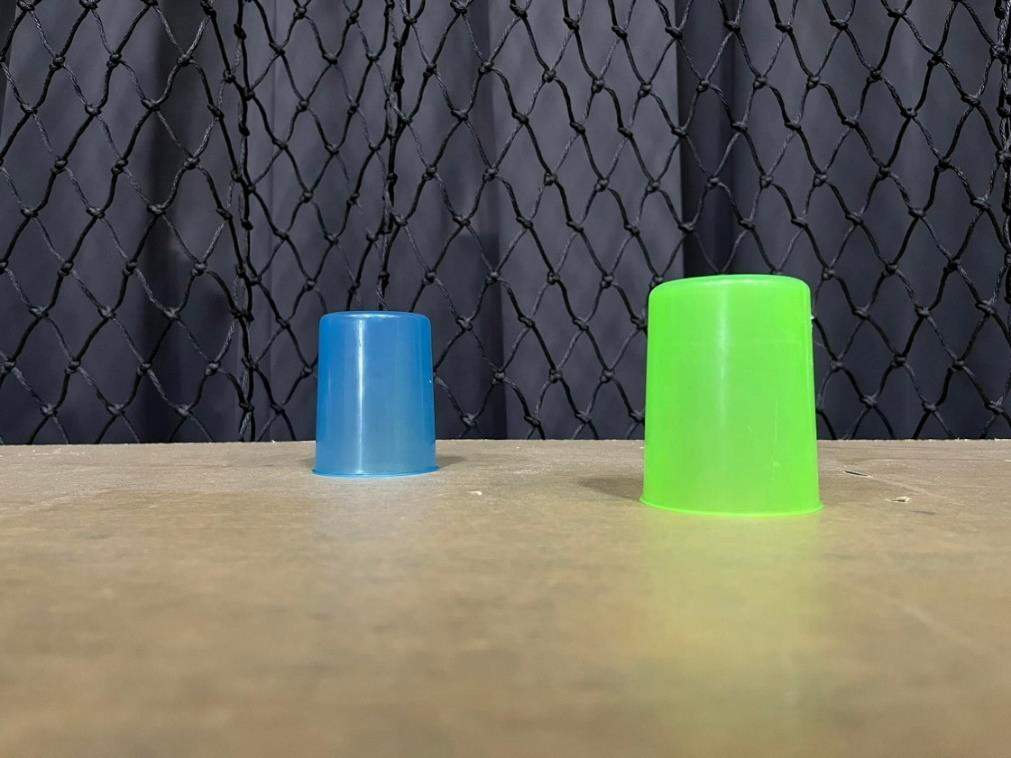

In [3]:
from torchvision.io import read_image

img_int = read_image('measure-object-distance/test.jpg')

print(img_int.size())
show(img_int)# c, h, w

Find objects in the picture

In [13]:
from torchvision.models.detection import  retinanet_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype

#find objects in the picture
input_int = torch.stack([img_int])
input = convert_image_dtype(input_int, dtype=torch.float)

#use pre train model 
model =  retinanet_resnet50_fpn(pretrained=True, progress=False)
model = model.eval()

outputs = model(input)
print( 'Number objects found:',outputs[0]['boxes'].size(0))
print(outputs)

Number objects found: 32
[{'boxes': tensor([[ 313.7096,  306.4053,  439.6842,  479.8136],
        [ 640.7320,  272.9416,  822.9241,  517.7004],
        [  13.9531,  433.8646, 1007.1155,  748.0748],
        [ 640.7727,  274.1519,  821.6493,  512.7799],
        [ 642.5720,  277.3840,  820.2700,  519.6612],
        [ 313.2036,  306.4336,  439.2124,  477.2533],
        [ 644.3716,  273.0923,  820.3553,  519.3207],
        [  20.2905,  400.0129,  891.4980,  582.1017],
        [ 641.8497,  274.5447,  821.8909,  516.8087],
        [  18.6668,    0.0000, 1006.5261,  448.2002],
        [  11.1326,  429.2604, 1002.2854,  746.4761],
        [ 115.1683,  309.4861,  878.2450,  519.8631],
        [  38.4329,  445.6378,  710.2921,  642.0217],
        [ 311.1289,  305.2122,  438.9075,  478.4245],
        [  10.6634,  428.0337, 1001.2063,  749.0574],
        [   8.8110,  425.1996, 1007.8785,  751.9538],
        [ 262.1068,  294.3828,  546.0312,  436.3290],
        [ 640.7727,  274.1519,  821.6493,  512

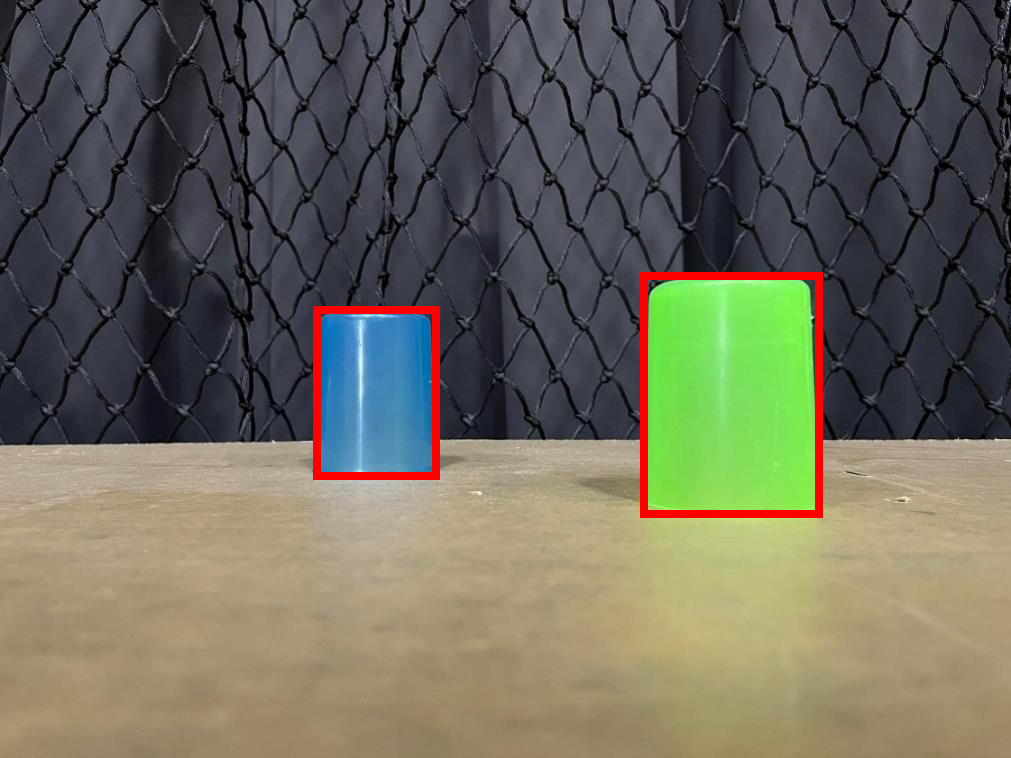

In [6]:
from torchvision.utils import draw_bounding_boxes

#focus only blue object and green object and draw bounding boxes to picture
score_threshold = .5 #select only objects with a score higher than .5
outputs_with_boxes =  draw_bounding_boxes(img_int, boxes = outputs[0]['boxes'][outputs[0]['scores'] > score_threshold], colors ='RED', width=8)
#bounding boxes in (xmin, ymin, xmax, ymax) 

show(outputs_with_boxes)

Find ref object--> Which object is Blue?

In [8]:
from PIL import Image


objs = outputs[0]['boxes'][outputs[0]['scores'] > score_threshold]


def obj_ref(objs, filename='measure-object-distance/test.jpg'):
  '''
  Find which boxes are ref object (blue object)
  '''
  blue_obj = None
  green_obj = None
  for obj in objs:
      obj = torch.Tensor.int(obj)

      with Image.open(filename) as img: 
          img.load()
      
      img_crob = img.crop((obj.numpy()))
      r, g, b = img.getpixel((img_crob.size[0]/2 ,img_crob.size[1]/2))

      if blue_obj is not None: pass
      else:
        if b>g :
          blue_obj = obj
      green_obj = obj
  return blue_obj, green_obj

blue_obj, green_obj = obj_ref(objs)


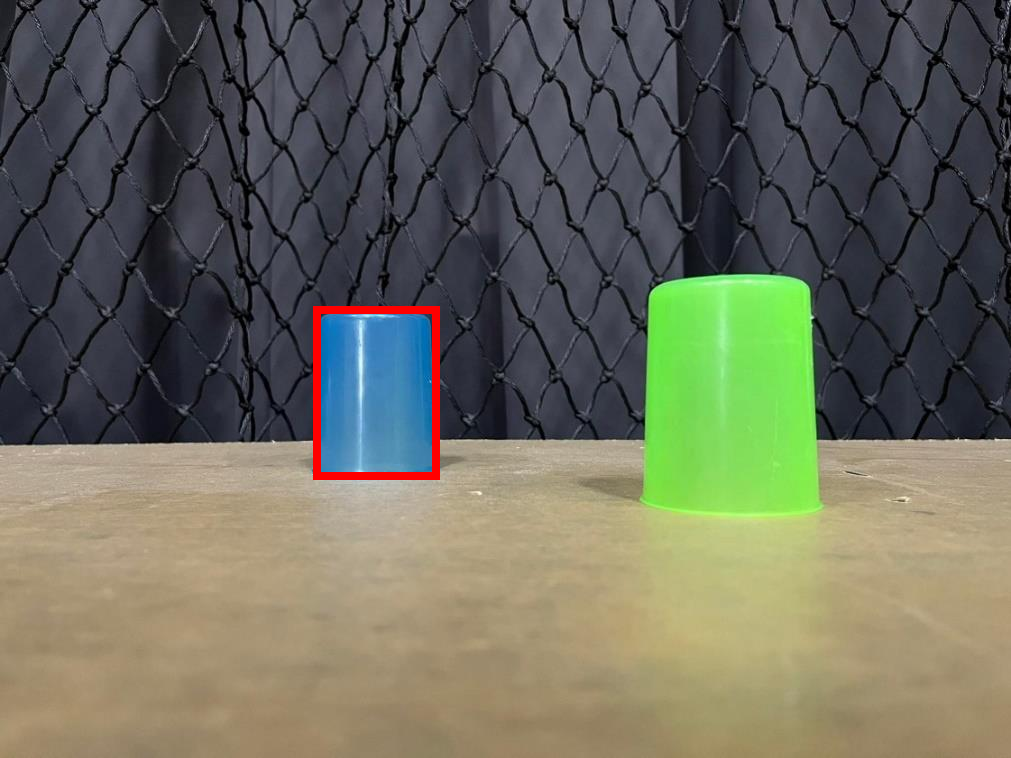

In [9]:
#Verify blue object is correct.
show(draw_bounding_boxes(img_int, boxes = blue_obj.view(1,-1), colors ='RED', width=8))

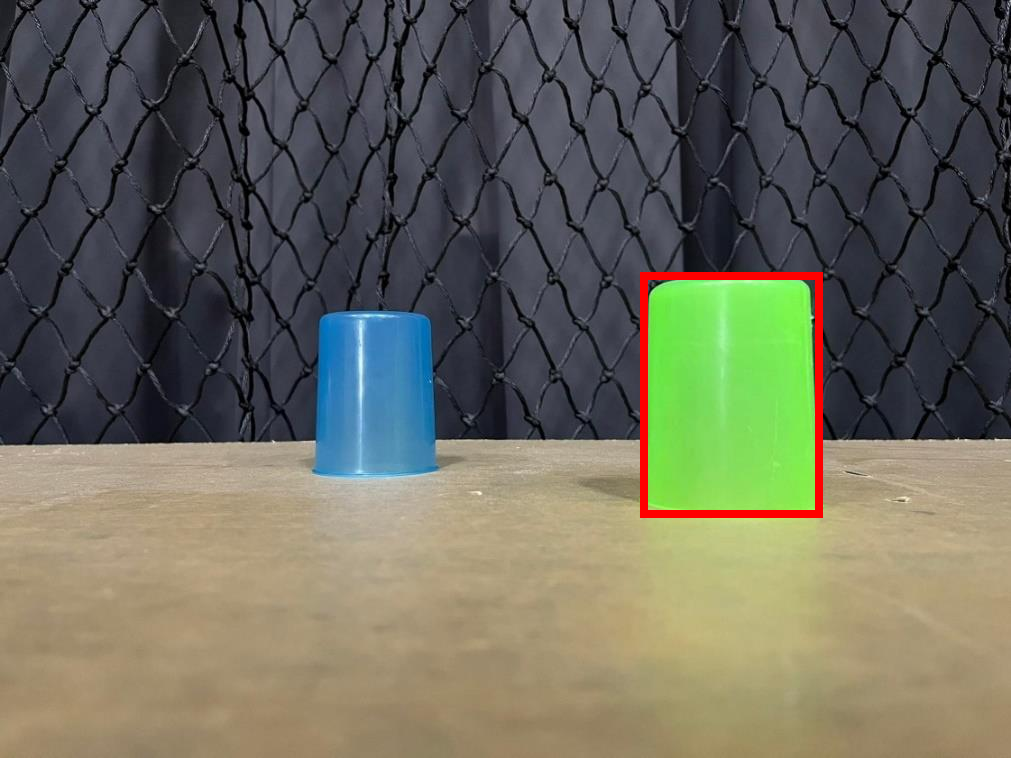

In [10]:
#Verify green  object is correct.
show(draw_bounding_boxes(img_int, boxes = green_obj.view(1,-1), colors ='RED', width=8))

Cal focal length and Distace

ref: [link1](https://stackoverflow.com/questions/6714069/finding-distance-from-camera-to-object-of-known-size), [link2](https://pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/), [link3](https://github.com/Asadullah-Dal17/Distance_measurement_using_single_camera/blob/main/distance.py)


$\frac{F}{D} = \frac{P}{W}$

where 

- F = focal length
- D = Distance (unit: cm)
- P = object width in pixels
- W = object width in cm.

In [21]:
#We know...
real_distance = 36 #cm
real_higth = 8 #cm -->y
real_width = 6.5 #cm -->x

In [22]:
ref_width = torch.abs(blue_obj[2] - blue_obj[0]) #pixel

# F = (P/W)*D
focal_length = (ref_width * real_distance) / real_width #(pixel*cm) / cm
obj2_width = torch.abs(green_obj[2] - green_obj[0]) #pixel

#D' = (W*F)/P
distance = (real_width * focal_length) / obj2_width #(cm*(pixel*cm) / cm)/pixel --> cm

print('the distance of the green object relative to the camera: ', distance.detach().numpy(), 'cm') #cm

the distance of the green object relative to the camera:  24.923077 cm


Visualization

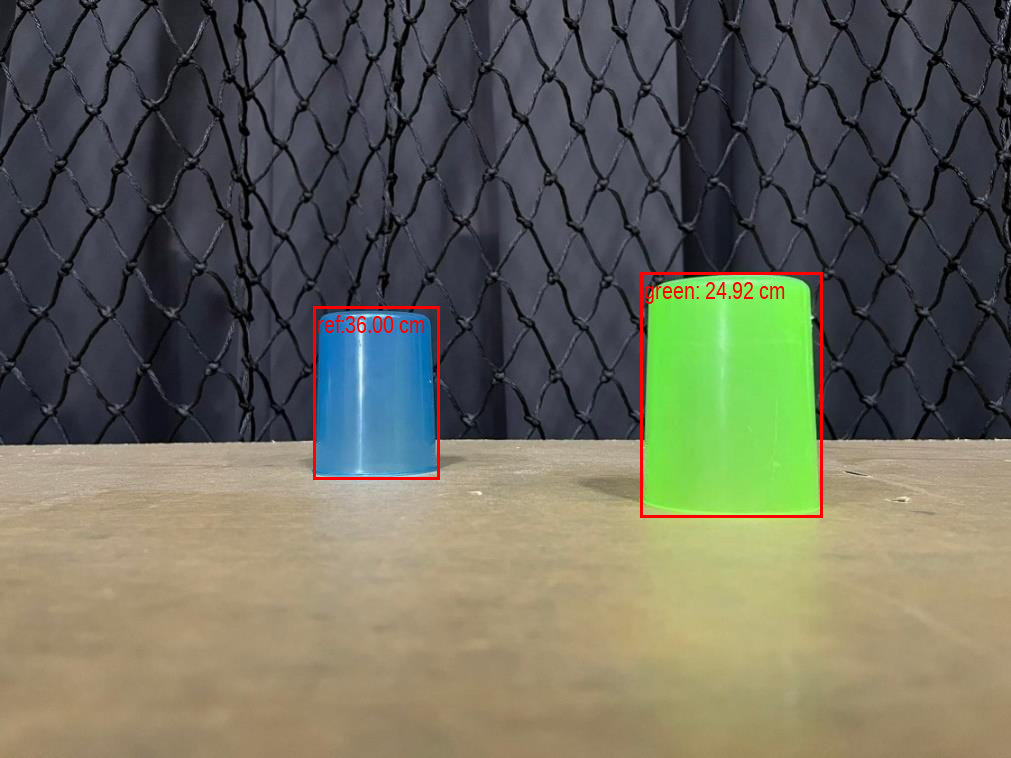

In [25]:

img_out = draw_bounding_boxes(img_int, 
                              boxes = torch.stack([blue_obj, green_obj],0), 
                              labels =['ref:{:.2f} cm'.format(real_distance),'green: {:.2f} cm'.format(distance.numpy())] ,
                              font = "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              font_size =24, 
                              colors ='RED' , 
                              width=3)

show(img_out)
img_out = T.ToPILImage()(img_out)
img_out.save('result.jpg')